# Contrail segmentation with Tensorflow

## Notebook features

- Working with preprocessed dataset. Source: https://www.kaggle.com/code/bencetar/contrail-dataset-preprocess    
    (filtered samples 20k->9k training and 1.8k->540 valid samples)
- Data augmentation applied
- Mixed precision training
- Weighted loss for class inbalance
- 5 block UNet model 

## Libraries


In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import albumentations as A

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Preprocessed dataset

The data used in this notebook is preprocessed in this notebook:
https://www.kaggle.com/code/bencetar/contrail-dataset-preprocess

The created datasets can be found:
- training images: https://www.kaggle.com/datasets/bencetar/contrail-train-imgs
- validation images: https://www.kaggle.com/datasets/bencetar/contrail-valid-imgs
- training masks: https://www.kaggle.com/datasets/bencetar/prep-train-masks
- validation masks: https://www.kaggle.com/datasets/bencetar/prep-valid-masks

## Create custom dataset

In [3]:
class CFG:
    """ Set the hyperparameters. """
    INPUT_IMG = (256, 256, 3)
    INPUT_LBL = (256, 256, 1)
    BATCH_SIZE = 8
    BUFFER_SIZE = 2000
    EPOCHS = 12
    LR = 5e-4

In [4]:
# data source
TEST_IMGS = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/test"
PREP_TRAIN_IMGS = "/kaggle/input/contrail-train-imgs/contrail_training"
PREP_VALID_IMGS = "/kaggle/input/contrail-valid-imgs/contrail_valid"
PREP_TRAIN_MSKS = "/kaggle/input/prep-train-masks"
PREP_VALID_MSKS = "/kaggle/input/prep-valid-masks"

# img name format: rgb_image_ID.npz
# msk name format: prep_mask_ID.npz

# Check out the preprocessed dataset:
print(f"Images in train: {len(os.listdir(PREP_TRAIN_IMGS))} in valid: {len(os.listdir(PREP_VALID_IMGS))}")
print(f"Masks in train: {len(os.listdir(PREP_TRAIN_MSKS))} in valid: {len(os.listdir(PREP_VALID_MSKS))}")

Images in train: 9149 in valid: 540
Masks in train: 9149 in valid: 540


In [5]:
# Define constants
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

# Data augmentation
augmentation = A.Compose([
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=45),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    ], p=0.4)
])

class ContrailDataset(tf.keras.utils.Sequence):
    """ Custom dataset with generator to load images and masks. """

    def __init__(self, img_folder=None, lbl_folder=None, training=True, subset_num=None, folds=None):
        self.img_folder = img_folder
        self.lbl_folder = lbl_folder
        self.training = training
        self.subset_num = subset_num
        self.folds = folds
        
        if self.training:
            self.correct_ids = [i.split("_")[-1][:-4] for i in os.listdir(self.img_folder)]
            self.subset_size = int(len(self.correct_ids)/self.folds)
            start = self.subset_size * (self.subset_num - 1)
            end = start + self.subset_size
            self.correct_ids = self.correct_ids[start:end]            
        else:
            self.correct_ids = os.listdir(self.img_folder)    
        
    def normalize_range(self, data, bounds):
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def __len__(self):
        return len(self.correct_ids)
            
    def __get_image(self, record_id):        
        if self.training:            
            with np.load(os.path.join(self.img_folder, f'rgb_image_{record_id}.npz')) as data:
                composite = np.asarray(data['data'][..., 4], dtype=np.float32) # take only current timestep
            return composite
        else:
            with open(os.path.join(self.img_folder, record_id, 'band_15.npy'), 'rb') as f:
                band15= np.load(f).astype(np.float32)
            with open(os.path.join(self.img_folder, record_id, 'band_14.npy'), 'rb') as f:
                band14 = np.load(f).astype(np.float32)
            with open(os.path.join(self.img_folder, record_id, 'band_11.npy'), 'rb') as f:
                band11 = np.load(f).astype(np.float32)
            r = self.normalize_range(band15 - band14, _TDIFF_BOUNDS)
            g = self.normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
            b = self.normalize_range(band14, _T11_BOUNDS)
            composite = np.clip(np.stack([r,g, b], axis=2), 0, 1)[..., 4]
            return composite

    def __get_label(self, record_id):
        with np.load(os.path.join(self.lbl_folder, f'prep_mask_{record_id}.npz')) as data:
            mask = np.expand_dims(data['data'], axis=-1).astype(np.float32)
        return mask

    def generator(self):
        for rec_id in self.correct_ids:
            if self.training:
                image = self.__get_image(rec_id)
                mask = self.__get_label(rec_id)                                               
                augmented = augmentation(image=image, mask=mask)                
                yield tf.convert_to_tensor(augmented["image"], dtype=tf.float32), tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)
            else:
                image = self.__get_image(rec_id)
                yield tf.convert_to_tensor(image, dtype=tf.float32)
            gc.collect()

## Define UNet model and losses

In [6]:
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2.0 * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)
    return score
    
def dice_loss(y_true, y_pred):
    dice_loss = 1 - dice_coef(y_true, y_pred)
    return dice_loss

def weighted_binary_crossentropy(y_true, y_pred):
    # In order to weight up the targets
    weights = tf.where(y_true == 1, 100.0, 1.0)  # 100 for positive class, 1 for negative class
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction="auto")(y_true, y_pred)
    weighted_loss = loss * weights
    return tf.reduce_mean(weighted_loss)

In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")


def conv_block(input_l, filters, encoder=True):
    # (simple conv: 5,5m double conv: 11,8m params)    
    conv_1 = tf.keras.layers.Conv2D(filters, 3, padding="same")(input_l)
    bn_1 = tf.keras.layers.BatchNormalization()(conv_1)
    relu_1 = tf.keras.activations.relu(bn_1)
    conv_2 = tf.keras.layers.Conv2D(filters, 3, padding="same")(relu_1)
    bn_2 = tf.keras.layers.BatchNormalization()(conv_2)
    relu_2 = tf.keras.activations.relu(bn_2)
    if encoder == True:
        maxpool = tf.keras.layers.MaxPooling2D((2,2))(relu_2) 
        return maxpool
    else:
        upscale = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(relu_2) 
        return upscale

def unet_encoder(input_layer):
    # Encoder part of Unet
    x = conv_block(input_layer, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    x = conv_block(x, 512)
    return x
    
def unet_decoder(input_layer):
    # Decoder part of Unet
    x = conv_block(input_layer, 512, encoder=False)
    x = conv_block(x, 256, encoder=False)
    x = conv_block(x, 128, encoder=False)
    x = conv_block(x, 64, encoder=False)
    x = conv_block(x, 32, encoder=False)    
    last_conv = tf.keras.layers.Conv2D(1, 1)(x)
    sigmoid_f32 = tf.keras.layers.Activation("sigmoid", dtype=tf.float32, name="sigmoid_f32")(last_conv)
    return sigmoid_f32

def UNET_model(input_shape, training=True):
    input_layer = tf.keras.layers.Input(shape=input_shape)
    encoder = unet_encoder(input_layer)
    decoder = unet_decoder(input_layer=encoder)
    model = tf.keras.Model(inputs=input_layer, outputs=decoder, name="unet_model")
    return model

In [8]:
# Model
model = UNET_model(input_shape=CFG.INPUT_IMG)

optimizer = tf.keras.optimizers.Adam(learning_rate=CFG.LR)

model.compile(
    loss=weighted_binary_crossentropy,
    optimizer=optimizer,
    metrics=[dice_coef]
)

# Check mixed precision setup
for layer in model.layers:
    print(layer.name, '--', layer.output_shape, '--', layer.dtype_policy, "--", layer.trainable)

input_1 -- [(None, 256, 256, 3)] -- <Policy "float32"> -- True
conv2d -- (None, 256, 256, 32) -- <Policy "mixed_float16"> -- True
batch_normalization -- (None, 256, 256, 32) -- <Policy "mixed_float16"> -- True
tf.nn.relu -- (None, 256, 256, 32) -- <Policy "mixed_float16"> -- True
conv2d_1 -- (None, 256, 256, 32) -- <Policy "mixed_float16"> -- True
batch_normalization_1 -- (None, 256, 256, 32) -- <Policy "mixed_float16"> -- True
tf.nn.relu_1 -- (None, 256, 256, 32) -- <Policy "mixed_float16"> -- True
max_pooling2d -- (None, 128, 128, 32) -- <Policy "mixed_float16"> -- True
conv2d_2 -- (None, 128, 128, 64) -- <Policy "mixed_float16"> -- True
batch_normalization_2 -- (None, 128, 128, 64) -- <Policy "mixed_float16"> -- True
tf.nn.relu_2 -- (None, 128, 128, 64) -- <Policy "mixed_float16"> -- True
conv2d_3 -- (None, 128, 128, 64) -- <Policy "mixed_float16"> -- True
batch_normalization_3 -- (None, 128, 128, 64) -- <Policy "mixed_float16"> -- True
tf.nn.relu_3 -- (None, 128, 128, 64) -- <Polic

In [9]:
model.summary()

Model: "unet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                        

## Model training

In [10]:
tf.keras.backend.clear_session()
gc.collect()

# Create datasets (taking all samples)
train_dataset = ContrailDataset(img_folder=PREP_TRAIN_IMGS, lbl_folder=PREP_TRAIN_MSKS, subset_num=1, folds=1)
valid_dataset = ContrailDataset(img_folder=PREP_VALID_IMGS, lbl_folder=PREP_VALID_MSKS, subset_num=1, folds=1)

# Create dataloaders
train_dataloader = tf.data.Dataset.from_generator(
    generator=train_dataset.generator,
    output_signature=(
        tf.TensorSpec(shape=CFG.INPUT_IMG, dtype=tf.float32),
        tf.TensorSpec(shape=CFG.INPUT_LBL, dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=CFG.BUFFER_SIZE).repeat().batch(CFG.BATCH_SIZE)

valid_dataloader = tf.data.Dataset.from_generator(
    generator=valid_dataset.generator,
    output_signature=(
        tf.TensorSpec(shape=CFG.INPUT_IMG, dtype=tf.float32),
        tf.TensorSpec(shape=CFG.INPUT_LBL, dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE).cache().batch(CFG.BATCH_SIZE)

# Callbacks
MC = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor="val_loss", save_best_only=True)
ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)

# Fit model
steps = len(train_dataset) // CFG.EPOCHS
history = model.fit(
    train_dataloader,
    validation_data=valid_dataloader,
    epochs=CFG.EPOCHS,
    steps_per_epoch=steps,
    callbacks=[MC, ES, LR],
)


Epoch 1/12
762/762 [==============================] - 2637s 3s/step - loss: 0.3323 - dice_coef: 0.0810 - val_loss: 0.1324 - val_dice_coef: 0.0316 - lr: 5.0000e-04
Epoch 2/12
762/762 [==============================] - 1820s 2s/step - loss: 0.2407 - dice_coef: 0.1060 - val_loss: 0.1208 - val_dice_coef: 0.0581 - lr: 5.0000e-04
Epoch 3/12
762/762 [==============================] - 1817s 2s/step - loss: 0.1959 - dice_coef: 0.1951 - val_loss: 0.1106 - val_dice_coef: 0.1033 - lr: 5.0000e-04
Epoch 4/12
762/762 [==============================] - 1772s 2s/step - loss: 0.1731 - dice_coef: 0.2487 - val_loss: 0.0953 - val_dice_coef: 0.1273 - lr: 5.0000e-04
Epoch 5/12
762/762 [==============================] - ETA: 0s - loss: 0.1478 - dice_coef: 0.3428
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
762/762 [==============================] - 1761s 2s/step - loss: 0.1478 - dice_coef: 0.3428 - val_loss: 0.0961 - val_dice_coef: 0.2384 - lr: 5.0000e-04
Epoch 6/12
762/762 [===

## Results

In [11]:
# Load in best model
best = "/kaggle/working/best_model.h5"
loaded_model = tf.keras.models.load_model(best, custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy, 'dice_coef':dice_coef})

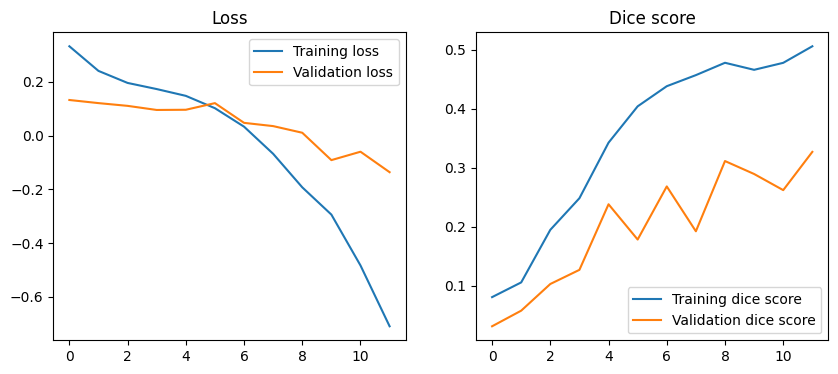

In [12]:
def plot_history(history, figsize=(10,4)):
    train_acc = history["dice_coef"]
    val_acc = history["val_dice_coef"]
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = [i for i in range(0,len(val_loss))]
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=figsize)
    ax1.plot(epochs, train_loss, label="Training loss")
    ax1.plot(epochs, val_loss, label="Validation loss")
    ax1.set_title("Loss")
    ax1.legend()
    ax2.plot(epochs, train_acc, label="Training dice score")
    ax2.plot(epochs, val_acc, label="Validation dice score")
    ax2.set_title("Dice score")
    ax2.legend()
    
plot_history(history.history)

## Prediction on test images

In [13]:
test_dataset = ContrailDataset(
    img_folder=TEST_IMGS,
    training=False,
)
test_dataloader = tf.data.Dataset.from_generator(
    generator=test_dataset.generator,
    output_types=tf.float32,
    output_shapes=(256, 256, 3),
).prefetch(tf.data.AUTOTUNE).batch(2)

test_preds = []
for tests in test_dataloader:
    for img in tests:
        sample = {}
        sample["image"] = img
        pred = loaded_model.predict(tf.expand_dims(img, axis=0))[0,:,:,0]
        print(pred.shape)
        sample["pred"] = pred
        test_preds.append(sample)

1/1 [==============================] - 2s 2s/step
(256, 256)
1/1 [==============================] - 0s 22ms/step
(256, 256)


(256, 256) (256, 256, 3) (256, 256)
(256, 256) (256, 256, 3) (256, 256)


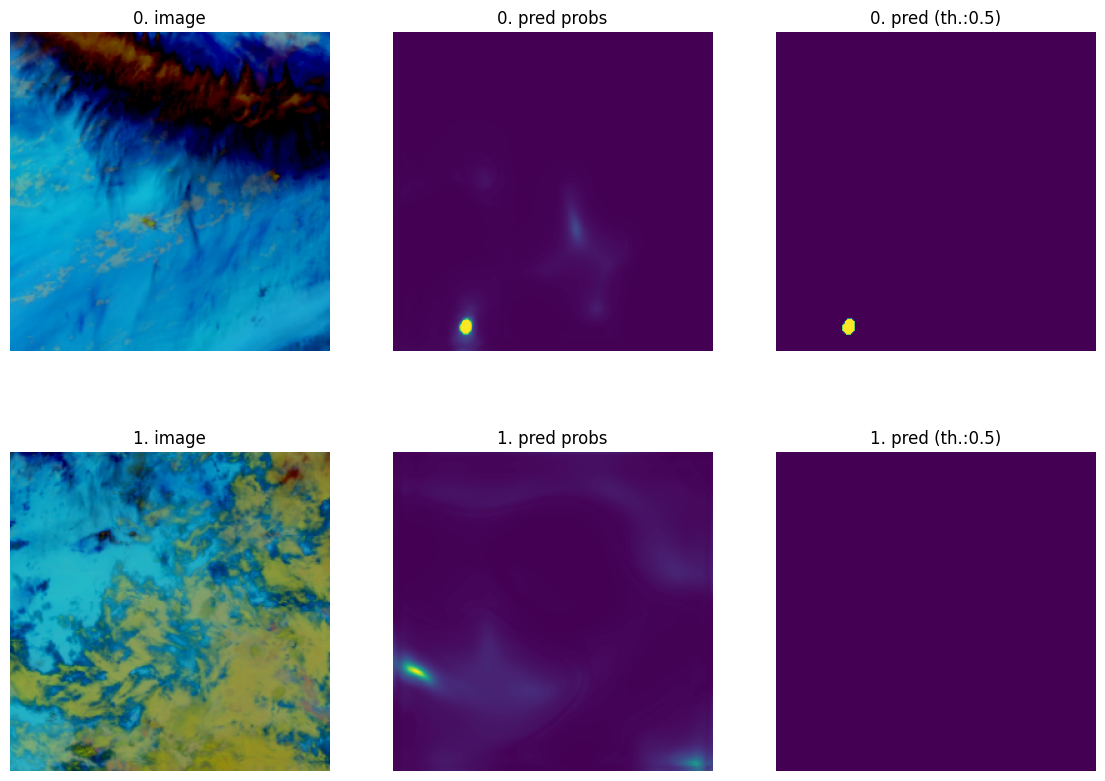

In [14]:
# Test prediction
fig, axs = plt.subplots(2, 3, figsize=(14,10))

for i, samp in enumerate(test_preds):
    trshld = 0.5
    img, pred_prob = samp["image"], samp["pred"]
    pred = (pred_prob > 0.5).astype(float)
    print(pred.shape, img.shape, pred_prob.shape)
    axs[i][0].imshow(img)
    axs[i][0].set_title(f"{i}. image")
    axs[i][0].axis("off")
    axs[i][1].imshow(pred_prob)
    axs[i][1].set_title(f"{i}. pred probs")
    axs[i][1].axis("off")
    axs[i][2].imshow(pred)
    axs[i][2].set_title(f"{i}. pred (th.:{trshld})")
    axs[i][2].axis("off")

## Prediction on validation set

In [15]:
valid_preds = []
for valid_batch in valid_dataloader.take(1):
    for img, msk in zip(valid_batch[0], valid_batch[1]): # [0]images, [1]masks
        sample = {}
        sample["image"] = img
        sample["mask"] = msk
        pred = loaded_model.predict(tf.expand_dims(img, axis=0), verbose=0)[0,:,:,0]
        sample["pred"] = pred
        valid_preds.append(sample)

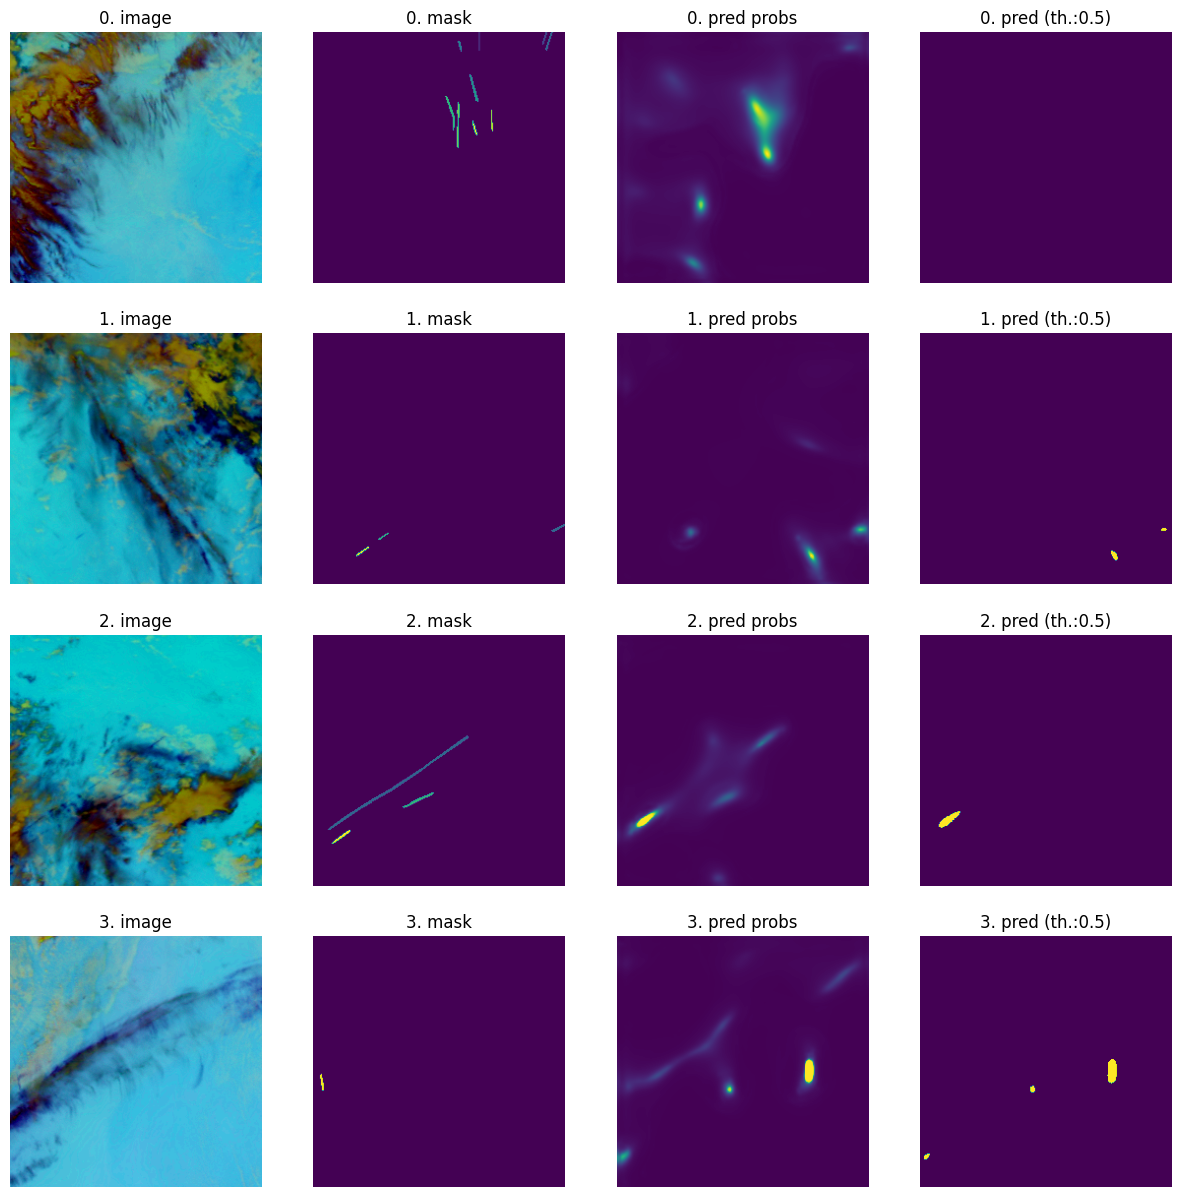

In [23]:
# Lets visualze some sample
fig, axs = plt.subplots(4, 4, figsize=(15,15))

for i, samp in enumerate(valid_preds[4:8]):
    trshld = 0.5
    img, msk, pred_prob = samp["image"], samp["mask"], samp["pred"]
    pred = (pred_prob > trshld).astype(float)
    axs[i][0].imshow(img)
    axs[i][0].set_title(f"{i}. image")
    axs[i][0].axis("off")
    axs[i][1].imshow(msk)
    axs[i][1].set_title(f"{i}. mask")
    axs[i][1].axis("off")
    axs[i][2].imshow(pred_prob)
    axs[i][2].set_title(f"{i}. pred probs")
    axs[i][2].axis("off")
    axs[i][3].imshow(pred)
    axs[i][3].set_title(f"{i}. pred (th.:{trshld})")
    axs[i][3].axis("off")

## Submission with RLE
submission code source: https://www.kaggle.com/code/inversion/contrails-rle-submission

In [17]:

def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

### Create naive submission
We'll use just band_08 and predict that the 1000 pixels with the highest numerical values are contrails.

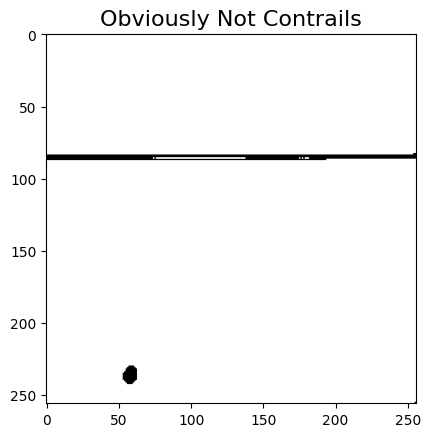

In [18]:
test1 = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1000834164244036115/band_08.npy"
test1 = np.load(test1).sum(axis=2)
test2 = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/1002653297254493116/band_08.npy"
test2 = np.load(test2).sum(axis=2)
test3 = (test_preds[0]["pred"] > 0.5).astype(float)

n = 1000

# https://stackoverflow.com/a/57105712
preds = np.c_[np.unravel_index(np.argpartition(test3.ravel(),-n)[-n:],test3.shape)]
mask = np.zeros((256, 256))
mask[preds[:, 0], preds[:, 1]] = 1

plt.imshow(mask, cmap='Greys')
plt.title("Obviously Not Contrails", fontsize='16')
plt.show()

In [19]:
# Convert to RLE
list_to_string(rle_encode(mask))

'85 4 341 4 597 4 853 4 1109 4 1365 4 1621 4 1877 4 2133 4 2389 4 2645 4 2901 4 3157 4 3413 4 3669 4 3925 4 4181 4 4437 4 4693 4 4949 4 5205 4 5461 4 5717 4 5973 4 6229 4 6485 4 6741 4 6997 4 7253 4 7509 4 7765 4 8021 4 8277 4 8533 4 8789 4 9045 4 9301 4 9557 4 9813 4 10069 4 10325 4 10581 4 10837 4 11093 4 11349 4 11605 4 11861 4 12117 4 12373 4 12629 4 12885 4 13141 4 13397 4 13653 4 13804 5 13909 4 14059 7 14165 4 14313 10 14421 4 14568 12 14677 4 14823 13 14933 4 15079 13 15189 4 15335 13 15445 4 15591 12 15701 4 15848 10 15957 4 16105 8 16213 4 16469 4 16725 4 16981 4 17237 4 17493 4 17749 4 18005 4 18261 4 18517 4 18773 4 19029 2 19032 1 19285 4 19541 2 19544 1 19797 2 19800 1 20053 2 20056 1 20309 2 20312 1 20565 2 20568 1 20821 2 20824 1 21077 2 21080 1 21333 2 21336 1 21589 2 21592 1 21845 2 21848 1 22101 2 22104 1 22357 2 22360 1 22613 2 22616 1 22869 2 22872 1 23125 2 23128 1 23381 2 23384 1 23637 2 23640 1 23893 2 23896 1 24149 2 24152 1 24405 2 24408 1 24661 2 24664 1 2491

## Automate submission

In [20]:
sub_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv"
submission = pd.read_csv(sub_path, index_col='record_id')
submission.head()

,encoded_pixels
record_id,
1000834164244036115,1 3 10 5
1002653297254493116,-


In [21]:
# Problem: we dont have ids.. we need to return that too with the generator...0
# But maybe test_preds[0] is 1000834164244036115
# and test_preds[1] is 1002653297254493116

test_im_0 = (test_preds[0]["pred"] > 0.5).astype(float)
preds_0 = np.c_[np.unravel_index(np.argpartition(test_im_0.ravel(),-n)[-n:],test_im_0.shape)]
mask_0 = np.zeros((256, 266))
mask_0[preds_0[:, 0], preds_0[:, 1]] = 1
submission.loc[1000834164244036115, 'encoded_pixels'] = list_to_string(rle_encode(mask_0))

test_im_1 = (test_preds[1]["pred"] > 0.5).astype(float)
preds_1 = np.c_[np.unravel_index(np.argpartition(test_im_1.ravel(),-n)[-n:],test_im_1.shape)]
mask_1 = np.zeros((256, 266))
mask_1[preds_1[:, 0], preds_1[:, 1]] = 1
submission.loc[1000834164244036115, 'encoded_pixels'] = list_to_string(rle_encode(mask_1))

submission.head()

,encoded_pixels
record_id,
1000834164244036115,86 3 341 4 597 4 853 4 1109 4 1365 4 1621 4 18...
1002653297254493116,-


In [22]:
submission.to_csv('submission.csv')

### Closing thoughts

The predictions and the dice score indicates that the model isn't absolutely clueless, although there should be further training needed, and maybe the class weighting ratios could be different (I guess 1/10 instead of 1/100 might be better) along with other parameters. Also more filters and more convolutions would be beneficial.